# DCI with $k_0$ and $k_1$ scaled by $\log (n / k)$

Purpose of this notebook is to identify what are acceptable parameters to choose for number of retrievals per simple index, number of total visits to points among the composites in terms of recall and/or approximation radius

many ideas were born and many ideas were killed in the making of this notebook

In [1]:
import numpy as np
import pandas as pd
from pydci import DCI
from sklearn.neighbors import NearestNeighbors
from pytest import approx
import timeit
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import math

Here are a helper function for calulating metrics related to the approximation radius 

In [2]:
def approx_ratio(X,ann,nn,q):
    if len(ann) == 0 or len(nn) == 0: return 0
    np.linalg.norm(nearest - q, axis=1)
    max_approx_dist =np.max(np.linalg.norm( X[ann] - q, axis=1))
    max_true_dist =np.max(np.linalg.norm( X[nn] - q, axis=1))
    return max_true_dist/max_approx_dist

Here is a run on 10k SHERPA with _two_ composite indices of only 5 simple indices a piece.  C_1 and C_2 are the constants that control max visits and max retrieve

In [62]:
# Setup data
X = pd.read_csv("../data/SHERPA.csv").to_numpy()
N = 10000
#N = X.shape[0]  # Sets number of points to look at
m=5
L=2
X = X[-N:, 2:]
X = np.unique(X, axis=0)
d = X.shape[1]
N = X.shape[0]  
# Set up DCI

dci = DCI(d, m, L)

# Run through data
step = 200
radius = 0.1


dci_query = []
dci_recall = []
dci_build = []
brute_build = []
brute_query = []
brute_recall = []
can_szs = []
insert_del_szs = []
approx_radii = []

#Max visits constant
C1 = 3
#Max retrieves constant 
C2 = 3
print("i \t k_0 \t k_1 \t size \t recall \t\t radius")

for i in range(step, N, step):

    
    # dci
    t0 = timeit.default_timer()
    dci.add(X[i - step:i, :])
    dci_build.append(timeit.default_timer() - t0)
    q = X[i, :].reshape(1, -1)
    k = 100 #int(radius*i)
    t0 = timeit.default_timer()
    
    #k_1 in the paper - Craig innovated on squaring the log which appears to work great for reasons not yet understood
    max_visits = int(C1*m*k*np.log(i/k)**2) + step
    #k_0 in the paper
    max_candidates =  int(C2*k*np.log(i/k)**2) + step

    (nearest_indices, nearest, can_sz, insert_del_sz) = dci.query(q, k, max_candidates, max_visits)  # Log growth

    dci_query.append(timeit.default_timer() - t0)
    
    # brute force
    t0 = timeit.default_timer()
    brute = NearestNeighbors(
        n_neighbors=k, algorithm='brute')
    brute.fit(X[:i, :])
    brute_build.append(timeit.default_timer() - t0)
    t0 = timeit.default_timer()
    true_distances, true_indices = brute.kneighbors(q)
    brute_query.append(timeit.default_timer() - t0)
    true_nearest = X[true_indices.ravel(), :]
    dci_intersection = np.intersect1d(nearest_indices, true_indices.ravel())
    brute_intersection = np.intersect1d(true_indices.ravel(), true_indices.ravel())
    dci_recall.append(len(dci_intersection) / k)
    brute_recall.append(len(brute_intersection) / k)
    can_szs.append(can_sz)
    insert_del_szs.append(insert_del_sz)
    
    approx_radii.append(approx_ratio(X[:i+1,:],nearest_indices,true_indices.reshape(-1),q))
    result_str = str(i) \
    +"\t"+str(max_candidates) \
    +"\t"+str(max_visits) \
    +"\t"+ str(can_szs[-1]) \
    +"\t"+str(dci_recall[-1]) \
    +"\t\t"+ str(approx_radii[-1])

    print(result_str)
results = {
    'dci': {'build': dci_build, 'query': dci_query, 'recall': dci_recall},
    'brute': {'build': brute_build, 'query': brute_query, 'recall': brute_recall}
}

i 	 k_0 	 k_1 	 size 	 recall 		 radius
200	344	920	153	0.82		0.9715591296853104
400	776	3082	400	1.0		1.0
600	1163	5015	600	1.0		1.0
800	1497	6686	800	1.0		1.0
1000	1790	8152	1000	1.0		1.0
1200	2052	9462	1200	1.0		1.0
1400	2289	10646	1400	1.0		1.0
1600	2506	11730	1600	1.0		1.0
1800	2706	12731	1800	1.0		1.0
2000	2892	13661	2000	1.0		1.0
2200	3066	14531	2200	1.0		1.0
2400	3230	15350	2400	1.0		1.0
2600	3384	16122	2600	1.0		1.0
2800	3531	16855	2800	1.0		1.0
3000	3670	17552	3000	1.0		1.0
3200	3803	18216	3200	1.0		1.0
3400	3930	18852	3400	1.0		1.0
3600	4052	19462	3600	1.0		1.0
3800	4169	20048	3800	1.0		1.0
4000	4282	20611	4000	1.0		1.0
4200	4391	21155	4200	1.0		1.0
4400	4496	21680	4313	1.0		1.0
4600	4597	22187	4243	1.0		1.0
4800	4695	22679	4361	1.0		1.0
5000	4791	23155	4194	1.0		1.0
5200	4883	23618	4176	1.0		1.0
5400	4973	24067	4197	1.0		1.0
5600	5061	24505	4182	1.0		1.0
5800	5146	24930	4002	1.0		1.0
6000	5229	25345	4103	1.0		1.0
6200	5309	25749	3811	1.0		1.0
6400	5388	26144	3816	1.0		1.0
6

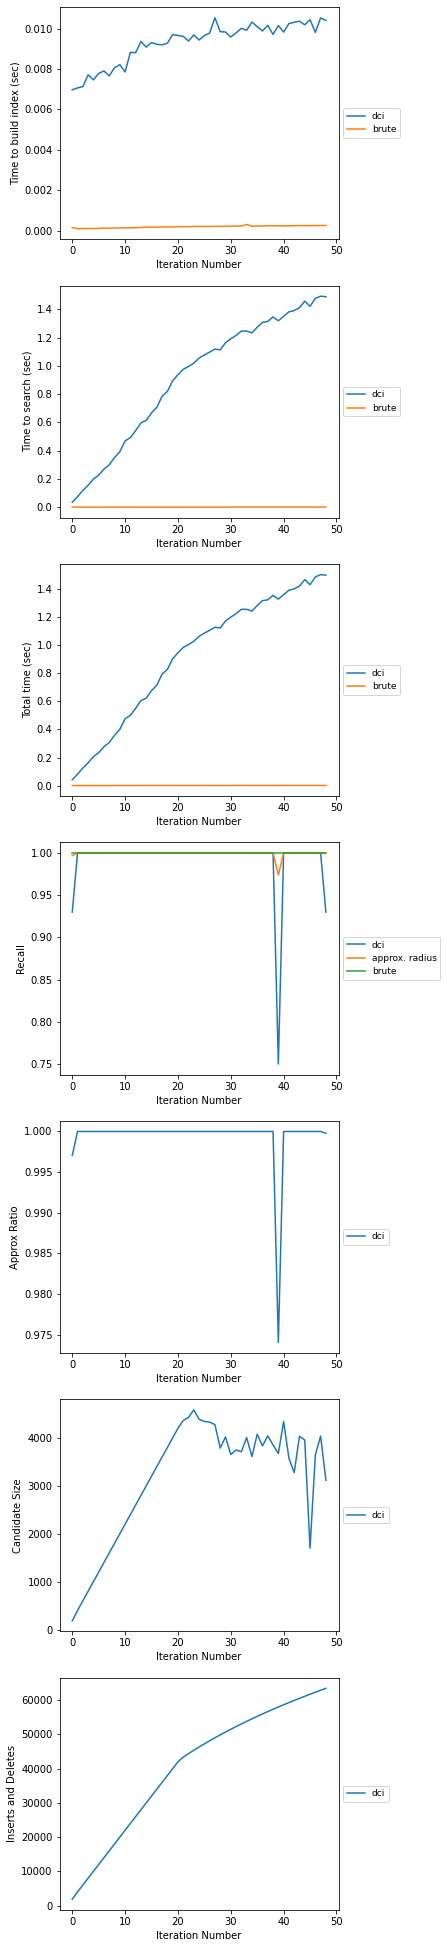

In [45]:
fig, axs = plt.subplots(7, 1, figsize=(5, 35))
for alg, result in results.items():
    build_times = np.array(result['build'])
    search_times = np.array(result['query'])
    recall = np.array(result['recall'])
    total_times = build_times + search_times
    axs[0].plot(build_times, label=alg)
    axs[1].plot(search_times, label=alg)
    axs[2].plot(total_times, label=alg)
    axs[3].plot(recall, label=alg)
    if alg == 'dci':
        axs[3].plot(approx_radii, label='approx. radius')
        axs[4].plot(approx_radii, label='dci')
        axs[5].plot(can_szs, label='dci')
        axs[6].plot(insert_del_szs, label='dci')

axs[0].set_ylabel('Time to build index (sec)')
axs[1].set_ylabel('Time to search (sec)')
axs[2].set_ylabel('Total time (sec)')
axs[3].set_ylabel('Recall')
axs[4].set_ylabel('Approx Ratio')
axs[5].set_ylabel('Candidate Size')
axs[6].set_ylabel('Inserts and Deletes')
for ax in axs:
    ax.set_xlabel('Iteration Number')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 9})
# fname = 'dci_brute.png'
# fig.savefig(fname, bbox_inches='tight')